In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network, noise_model
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats

In [4]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

[ 1. ,  1.1,  1.4,  1.5,  2. ,  2.1,  2.4,  2.5,  3. ,  3.1,  3.4,
        3.5,  4. ,  9. ,  9.1,  9.3,  9.4,  9.5, 11.1, 11.5, 12.1, 12.5,
       13. , 13.1, 13.5, 14. ]

In [5]:
photoz_archive = archive(path = parent_dir, only_zspec=True, flags_kept=[1. , 1.1, 1.4, 1.5, 2,2.1,2.4,2.5,3., 3.1, 3.4, 3.5,  4., 9. , 9.1, 9.3, 9.4, 9.5,11.1, 11.5, 12.1, 12.5, 13. , 13.1, 13.5, 14, ])
f, ferr, specz, specqz = photoz_archive.get_training_data()

(array([6.5332e+04, 4.0236e+04, 1.6535e+04, 6.8350e+03, 1.5660e+03,
        1.2800e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.5160e+03]),
 array([7.00000e-04, 1.00063e+00, 2.00056e+00, 3.00049e+00, 4.00042e+00,
        5.00035e+00, 6.00028e+00, 7.00021e+00, 8.00014e+00, 9.00007e+00,
        1.00000e+01]),
 <BarContainer object of 10 artists>)

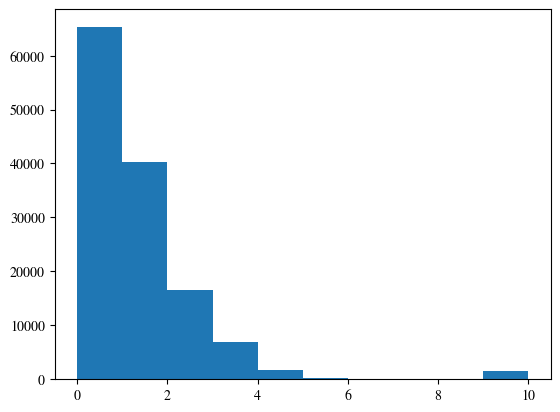

In [27]:
plt.hist(specz)

In [7]:
nnz = Photoz_network(num_gauss=6)
nn_noise = noise_model()

In [8]:
insight = Insight_module(nnz, batch_size=100,model_noise=nn_noise)


In [9]:
insight.train(input_data=f, 
              target_data=specz, 
              nepochs=100, 
              step_size = 200, 
              val_fraction=0.1, 
              lr=1e-3
             )

training_loss:0.39371058344841003 testing_loss:0.4389015734195709
training_loss:0.19797253608703613 testing_loss:0.028779149055480957
training_loss:-0.30978748202323914 testing_loss:-0.009356728754937649
training_loss:0.11645088344812393 testing_loss:0.26183879375457764
training_loss:0.5900436043739319 testing_loss:-0.08813679218292236
training_loss:-0.1699477881193161 testing_loss:-0.33997437357902527
training_loss:-0.2229994386434555 testing_loss:-0.24826037883758545
training_loss:-0.20083081722259521 testing_loss:-0.0863843560218811
training_loss:-0.5149155259132385 testing_loss:-0.21610473096370697
training_loss:-0.2465800642967224 testing_loss:-0.5012057423591614
training_loss:-0.16638655960559845 testing_loss:-0.21807952225208282
training_loss:-0.17784297466278076 testing_loss:0.1444094032049179
training_loss:0.11283282190561295 testing_loss:-0.39694344997406006
training_loss:-0.08972031623125076 testing_loss:0.08812128752470016
training_loss:-0.33778735995292664 testing_loss:0.3

In [14]:
insight.train_noise(input_data=f, 
              target_data=specz, 
              noise_condition=f,
              nepochs=300, 
              step_size = 200, 
              val_fraction=0.1, 
              lr=1e-3,
              lr_noise=1e-3
                    
             )

training_loss:-1.5718319416046143 testing_loss:-1.561311960220337
training_loss:-1.5752161741256714 testing_loss:-1.71945321559906
training_loss:-1.4990594387054443 testing_loss:-1.4010117053985596
training_loss:-1.417802333831787 testing_loss:-1.2604737281799316
training_loss:-1.4210973978042603 testing_loss:-1.2300392389297485
training_loss:-1.3646354675292969 testing_loss:-1.50438392162323
training_loss:-1.1057387590408325 testing_loss:-0.4505879580974579
training_loss:-1.521061897277832 testing_loss:-1.6606510877609253
training_loss:-1.3077646493911743 testing_loss:-1.474052906036377
training_loss:-1.3729846477508545 testing_loss:-1.8762184381484985
training_loss:-1.4259907007217407 testing_loss:-1.4703887701034546
training_loss:-1.162214994430542 testing_loss:-1.03268301486969
training_loss:-1.3876771926879883 testing_loss:-1.6355230808258057
training_loss:-1.299723744392395 testing_loss:-1.8092972040176392
training_loss:-1.6616750955581665 testing_loss:-0.7362287044525146
trainin

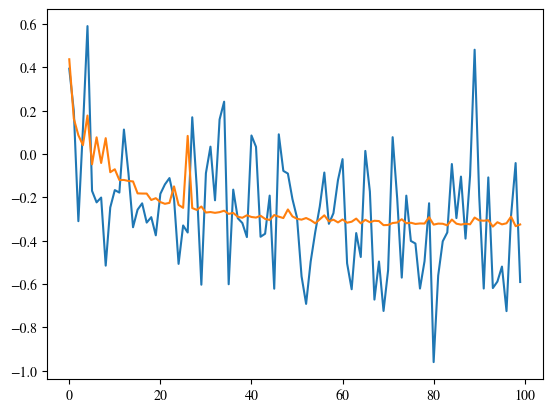

In [10]:
plt.plot(insight.loss_train, label = 'Train')
plt.plot(insight.loss_validation, label ='Val')

#plt.ylim(-2,0)

In [12]:
f_test, ferr_test, specz_test, VIS_mag_test = photoz_archive.get_testing_data()

In [13]:
f_test.shape

(11347, 6)

In [14]:
z,zerr = insight.get_photoz(input_data=torch.Tensor(f_test), target_data=torch.Tensor(specz_test))

Text(0, 0.5, '$z$')

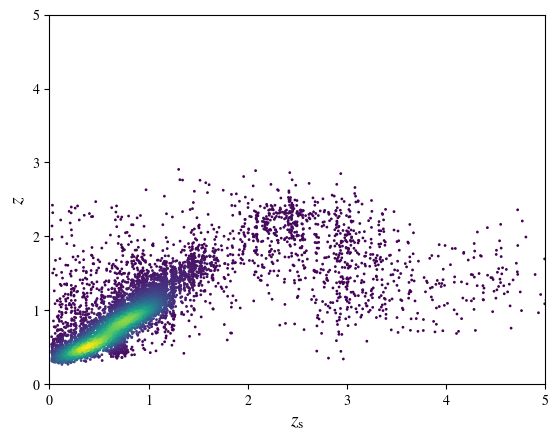

In [15]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([specz_test,z])
zd = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
plt.scatter(specz_test, z,c=zd, s=1)
plt.xlim(0,5)
plt.ylim(0,5)

plt.xlabel(r'$z_{\rm s}$', fontsize = 14)
plt.ylabel('$z$', fontsize = 14)

Text(0, 0.5, '$z$')

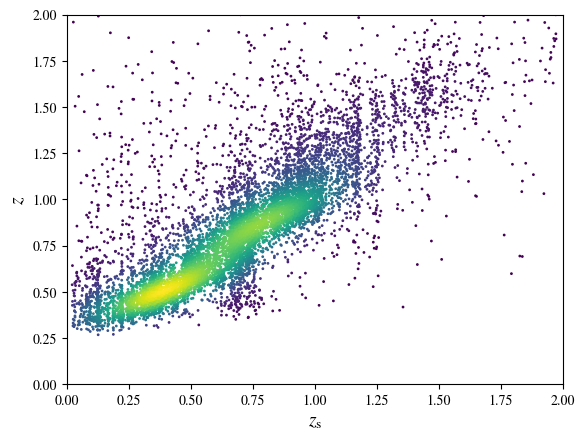

In [17]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([specz_test,z])
#zd = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
plt.scatter(specz_test, z,c=zd, s=1)
plt.xlim(0,2)
plt.ylim(0,2)

plt.xlabel(r'$z_{\rm s}$', fontsize = 14)
plt.ylabel('$z$', fontsize = 14)

In [18]:
VISmag = photoz_archive.get_VIS_mag(photoz_archive.cat_test)

In [19]:
df_test = pd.DataFrame(np.c_[VISmag, specz_test,z,zerr], columns = ['VISmag','zs','z','zuncert'])
df_test['zwerr'] = (df_test.z -df_test.zs) / (1+df_test.zs)

In [20]:
df_test = df_test[df_test.VISmag<25]
df_test = df_test[df_test.z<4]

In [21]:
def plot_photoz(df, nbins,xvariable,metric, type_bin='bin'):
    bin_edges = stats.mstats.mquantiles(df[xvariable].values, np.linspace(0.01,1,nbins))
    ydata,xdata = [],[]
    
    
    for k in range(len(bin_edges)-1):
        edge_min = bin_edges[k]
        edge_max = bin_edges[k+1]

        mean_mag =  (edge_max + edge_min) / 2
        
        if type_bin=='bin':
            df_plot = df_test[(df_test[xvariable] > edge_min) & (df_test[xvariable] < edge_max)]
        elif type_bin=='cum':
            df_plot = df_test[(df_test[xvariable] < edge_max)]
        else:
            raise ValueError("Only type_bin=='bin' for binned and 'cum' for cumulative are supported")


        xdata.append(mean_mag)
        if metric=='sig68':
            ydata.append(sigma68(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
        elif metric=='bias':
            ydata.append(np.median(df_plot.zwerr))
            

            ylab=r'Median $[\Delta z\ /\ (1 + z)]$'
        elif metric=='nmad':
            ydata.append(nmad(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
            plt.axhline(y=0.05, ls='--', color ='black')
        elif metric=='outliers':
            ydata.append(len(df_plot[np.abs(df_plot.zwerr)>0.15])/len(df_test) *100)
            ylab=r'$\eta$ [%]'
            
    if xvariable=='VISmag':
        xlab='VIS'
    elif xvariable=='zs':
        xlab=r'$z_{\rm spec}$'
    elif xvariable=='z':
        xlab=r'$z$'

    plt.plot(xdata,ydata, ls = '-', marker = '.', color = 'crimson',lw = 1, label = '')
    
    if metric=='bias':
        plt.fill_between(xdata, y1=-0.002, y2=0.002, color ='grey', alpha=0.5)
    plt.ylabel(f'{ylab}', fontsize = 18)
    plt.xlabel(f'{xlab}', fontsize = 16)

    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.grid(False)
    
    plt.show()
   

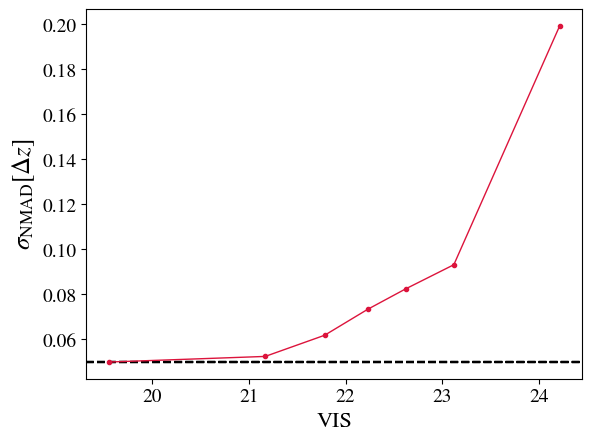

In [22]:
plot_photoz(df_test, 8,'VISmag','nmad', type_bin='bin')

In [23]:
nmad(df_test[df_test.VISmag<25].zwerr)

0.08255701848632314

In [24]:
df_test = df_test[df_test.VISmag<25]

In [25]:
len(df_test[np.abs(df_test.zwerr)>0.15])/len(df_test)

0.24392014519056263

In [ ]:
nmad, nu
secure: 0.0506, 0.135
less secure: 0.0512, 0.1268
nonsecure: 0.0516134, 0.12724
isolated_NB 0.0509, 0.1296
secure_AGN: 0.05112, 0.13379
all_sample: 0.04972, 0.1291

In [28]:
torch.save(insight.model.state_dict(),'/data/astro/scratch/lcabayol/Euclid/NNphotozs/models/insight_v0.pt')
           


In [176]:
df_test.to_csv('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df6.csv', sep=',')

In [177]:
# Create a list of additional header lines
header_lines = [
    "# Training spect-zs with a strict quality cut ALL",
    "#6 MDN components",
    "#Gaussian loss function",
    "# For 300 epochs with lr0=1e-3 + 150 epochs with lr=1e-4",
    "# Date: 2023-10-16",
]

# Write DataFrame to a CSV file with custom header lines
with open('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df6.csv', 'w') as f:
    for line in header_lines:
        f.write(line + '\n')
    df_test.to_csv(f, header=True, index=False, line_terminator='\n')


In [38]:
df_test_strict = df_test.copy()

In [72]:
df_test_Lessstrict = df_test.copy()

In [98]:
df_test_nonsecure = df_test.copy()

In [120]:
df_test_also_IEL = df_test.copy()

In [156]:
df_test_also_IEL_secureAGN = df_test.copy()

In [178]:
df_test_ALL = df_test.copy()

In [208]:
df_test_ALL

,VISmag,zs,z,zuncert,zwerr
0,23.103798,1.103000,1.123285,0.465454,0.009646
1,22.471019,0.468800,0.389439,0.154614,-0.054032
2,21.853940,0.694600,0.634368,0.170204,-0.035543
3,22.005561,0.649200,0.581555,0.215350,-0.041017
4,22.204387,0.666900,0.572430,0.158296,-0.056674
...,...,...,...,...,...
11342,22.449399,0.690462,0.792816,0.280725,0.060548
11343,22.102501,0.915746,0.974553,0.158990,0.030696
11344,22.982543,0.721060,0.711418,0.231749,-0.005603
11345,20.037661,0.345100,0.368380,0.087699,0.017307


In [209]:
bin_edges = stats.mstats.mquantiles(df_test_ALL['VISmag'].values, np.linspace(0.01,1,8))

In [210]:
xdata

[19.554272474077738,
 21.169647990059076,
 21.7830965615125,
 22.226921166342585,
 22.620076375946915,
 23.11603878467563,
 24.20806406175233]

In [206]:
xvariable = 'VISmag'
xdata, ystric,ylessSecure, yNonSecure, y_IEL, ysecAGN, yAll = [],[],[],[],[],[], []
for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    

    mean_mag =  (edge_max + edge_min) / 2
    
    xdata.append(mean_mag)
    
    df_plot_strict = df_test_strict[(df_test_strict[xvariable] > edge_min) & (df_test_strict[xvariable] < edge_max)]
    df_plot_LessStrict = df_test_Lessstrict[(df_test_Lessstrict[xvariable] > edge_min) & (df_test_Lessstrict[xvariable] < edge_max)]
    df_plot_nonSecure = df_test_nonsecure[(df_test_nonsecure[xvariable] > edge_min) & (df_test_nonsecure[xvariable] < edge_max)]
    df_plot_IEL = df_test_also_IEL[(df_test_also_IEL[xvariable] > edge_min) & (df_test_also_IEL[xvariable] < edge_max)]
    df_plot_secureAGN = df_test_also_IEL_secureAGN[(df_test_also_IEL_secureAGN[xvariable] > edge_min) & (df_test_also_IEL_secureAGN[xvariable] < edge_max)]
    df_plot_all = df_test_ALL[(df_test_ALL[xvariable] > edge_min) & (df_test_ALL[xvariable] < edge_max)]
    
    
    ystric.append(nmad(df_plot_strict.zwerr))
    ylessSecure.append(nmad(df_plot_LessStrict.zwerr))
    yNonSecure.append(nmad(df_plot_nonSecure.zwerr))
    y_IEL.append(nmad(df_plot_IEL.zwerr))
    ysecAGN.append(nmad(df_plot_secureAGN.zwerr))
    yAll.append(nmad(df_plot_all.zwerr))

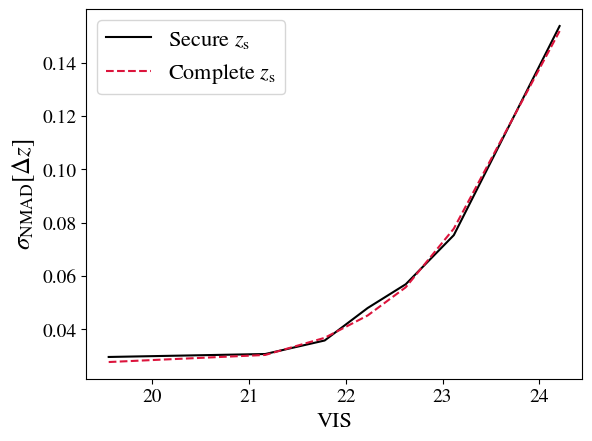

In [207]:
plt.plot(xdata, ystric, label=r'Secure $z_{\rm s}$', color = 'black')
#plt.plot(xdata, ylessSecure)
#plt.plot(xdata, yNonSecure)
#plt.plot(xdata, y_IEL)
#plt.plot(xdata, ysecAGN)
plt.plot(xdata, yAll,label=r'Complete $z_{\rm s}$', color = 'crimson', ls='--' )



plt.ylabel(r'$\sigma_{\rm NMAD} [\Delta z]$', fontsize = 18)
plt.xlabel(f'VIS', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.grid(False)

plt.legend(fontsize=16)

plt.show()

In [ ]:
def plot_photoz(df, nbins,xvariable,metric, type_bin='bin'):
    bin_edges = stats.mstats.mquantiles(df[xvariable].values, np.linspace(0.01,1,nbins))
    ydata,xdata = [],[]
    
    
    for k in range(len(bin_edges)-1):
        edge_min = bin_edges[k]
        edge_max = bin_edges[k+1]

        mean_mag =  (edge_max + edge_min) / 2
        
        if type_bin=='bin':
            df_plot = df_test[(df_test[xvariable] > edge_min) & (df_test[xvariable] < edge_max)]
        elif type_bin=='cum':
            df_plot = df_test[(df_test[xvariable] < edge_max)]
        else:
            raise ValueError("Only type_bin=='bin' for binned and 'cum' for cumulative are supported")


        xdata.append(mean_mag)
        if metric=='sig68':
            ydata.append(sigma68(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
        elif metric=='bias':
            ydata.append(np.median(df_plot.zwerr))
            

            ylab=r'Median $[\Delta z\ /\ (1 + z)]$'
        elif metric=='nmad':
            ydata.append(nmad(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
            plt.axhline(y=0.05, ls='--', color ='black')
        elif metric=='outliers':
            ydata.append(len(df_plot[np.abs(df_plot.zwerr)>0.15])/len(df_test) *100)
            ylab=r'$\eta$ [%]'
            
    if xvariable=='VISmag':
        xlab='VIS'
    elif xvariable=='zs':
        xlab=r'$z_{\rm spec}$'
    elif xvariable=='z':
        xlab=r'$z$'

    plt.plot(xdata,ydata, ls = '-', marker = '.', color = 'crimson',lw = 1, label = '')
    
    if metric=='bias':
        plt.fill_between(xdata, y1=-0.002, y2=0.002, color ='grey', alpha=0.5)
    plt.ylabel(f'{ylab}', fontsize = 18)
    plt.xlabel(f'{xlab}', fontsize = 16)

    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.grid(False)
    
    plt.show()
   